<a href="https://colab.research.google.com/github/robertosgpontes/osem/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Formulação Geral do Problema

O problema apresentado pode ser formulado através de uma

\begin{equation}
	\max  \sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} = \max \sum_{i=1}^{n}{C_{i}^1X_i}
\end{equation}
e
\begin{equation}
\min \sum_{i=1}^{n}{C_{i}^2X_i}
\end{equation}


Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


# Methodology

https://www.supplychaindataanalytics.com/multi-objective-linear-optimization-with-pulp-in-python/

https://pythonhealthcare.org/tag/pareto-front/



### Approach 1: Solution with Hierarchical Methodology

Maximizing for one objective, then adding it as a constraint and solving for the other objective

#### 1.1. First Step

\begin{equation}
S_1 = \max \sum_{i=1}^{n}{C_{i}^1X_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}

#### 1.2. Second Step


\begin{equation}
\min \sum_{i=1}^{n}{C_{i}^2X_i}
\end{equation}
Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
\max \sum_{i=1}^{n}{C_{i}^1X_i} \geq S_1
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


## Approach 2: Solution with ...

\begin{equation}
	\max  \alpha\sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} - (1-\alpha)\sum_{i=1}^{n}{C_iX_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}

# General Definitions

## Language

In [166]:
% pip install pulp
!rm /content/utils.py
!wget https://raw.githubusercontent.com/robertosgpontes/osem/main/utils.py
%run /content/utils.py

--2021-08-21 16:23:57--  https://raw.githubusercontent.com/robertosgpontes/osem/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1971 (1.9K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1.92K  --.-KB/s    in 0s      

2021-08-21 16:23:57 (36.6 MB/s) - ‘utils.py’ saved [1971/1971]



In [154]:
# Python libraries used to solve the problem Linear Programing
import pulp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Problem Solution

In [155]:
NUM_ITER = 1000

# Solution

##Paper 1 (P1): Optimizing the Management of Soil Erosion

Nikkami, Davood & Elektorowicz, Maria & MEHUYS, GUY. (2002). Optimizing the Management of Soil Erosion. Water Quality Research Journal in Canada. 37. 10.2166/wqrj.2002.038. 

### Model Parameter

In [156]:
# Variáveis do modelo

C = np.array([[10.54394,  0.0469 ,  0.59679,  0.02194],
              [1.41, 4.99, 2.41, 6.24]])

A = np.array([  [1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 0, 1, 0],
                [1, 1, 1, 1],
                [1, 0, 0, 0],
                [0, 1, 0, 0]])

b = np.array([[557],[1143],[1577],[1700],[10310],[160],[6990]])

In [157]:
CIni = C

In [158]:
CIni

array([[10.54394,  0.0469 ,  0.59679,  0.02194],
       [ 1.41   ,  4.99   ,  2.41   ,  6.24   ]])

In [159]:
#MinMax
CMinMax = (C - C.min()) / (C.max() - C.min())

In [160]:
CMinMax

array([[1.        , 0.00237217, 0.05463315, 0.        ],
       [0.13191979, 0.47215929, 0.22695875, 0.59095799]])

In [161]:
CStandardization = (C - C.mean()) / C.std()

In [162]:
CStandardization

array([[ 2.08568285, -0.92932991, -0.77138773, -0.93649905],
       [-0.53781345,  0.4904522 , -0.25058841,  0.8494835 ]])

In [163]:
C = CMinMax

### Solution


#### Approach 1

##### Step 1

In [164]:
linearProblem = pulp.LpProblem("First_Objective_Max",pulp.LpMaximize)

X = create_x_variables()

linearProblem += f(C[0], X)

linearProblem = load_model(linearProblem, A, X, b)

solution = linearProblem.solve()

In [169]:
print_solution(solution, linearProblem, X)

TypeError: ignored

In [135]:
f1_max = pulp.value(linearProblem.objective)

##### Step 2

In [136]:
linearProblem = pulp.LpProblem("Second_Objective_Min",pulp.LpMinimize)

X = create_x_variables()

linearProblem += f(C[1], X)

linearProblem = load_model(linearProblem, A, X, b)

linearProblem += f(C[0], X) >= f1_max

solution2 = linearProblem.solve()

In [137]:
print(linearProblem)

Second_Objective_Min:
MINIMIZE
0.1319197871127162*x1 + 0.472159285306976*x2 + 0.22695875308876645*x3 + 0.5909579927770388*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

_C8: x1 + 0.00237217259076 x2 + 0.0546331495913 x3 >= 639.870095989

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous



In [138]:
print(str(pulp.LpStatus[solution2])+" ; min_value = "+str(pulp.value(linearProblem.objective))+
      " ; x1_opt = "+str(pulp.value(X[0][0]))+
      " ; x2_opt = "+str(pulp.value(X[1][0]))+
      " ; x3_opt = "+str(pulp.value(X[2][0]))+
      " ; x4_opt = "+str(pulp.value(X[3][0])))

Optimal ; min_value = 4398.184622695306 ; x1_opt = 557.0 ; x2_opt = 8610.0 ; x3_opt = 1143.0 ; x4_opt = 0.0


#### Approach 2

In [117]:
alpha_lin = np.linspace(0, 1, NUM_ITER)

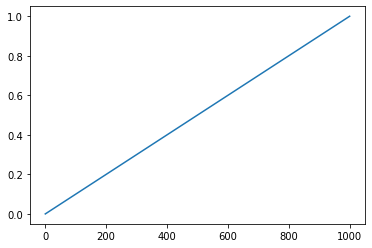

In [118]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_lin)

In [119]:
df_solution_lin = run_models(alpha_lin, C, A, b)

In [120]:
df_solution_lin

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.000000,Optimal,557.0,8610.0,1143.0,0.0,-4398.184623,639.870096,-4398.184623
1,1,0.001001,Optimal,557.0,8610.0,1143.0,0.0,-4393.141525,639.870096,-4398.184623
2,2,0.002002,Optimal,557.0,8610.0,1143.0,0.0,-4388.098427,639.870096,-4398.184623
3,3,0.003003,Optimal,557.0,8610.0,1143.0,0.0,-4383.055329,639.870096,-4398.184623
4,4,0.004004,Optimal,557.0,8610.0,1143.0,0.0,-4378.012231,639.870096,-4398.184623
...,...,...,...,...,...,...,...,...,...,...
995,995,0.995996,Optimal,557.0,8610.0,1143.0,0.0,619.697705,639.870096,-4398.184623
996,996,0.996997,Optimal,557.0,8610.0,1143.0,0.0,624.740803,639.870096,-4398.184623
997,997,0.997998,Optimal,557.0,8610.0,1143.0,0.0,629.783900,639.870096,-4398.184623
998,998,0.998999,Optimal,557.0,8610.0,1143.0,0.0,634.826998,639.870096,-4398.184623


In [ ]:
alpha_sig_004 = sig(-0.004)

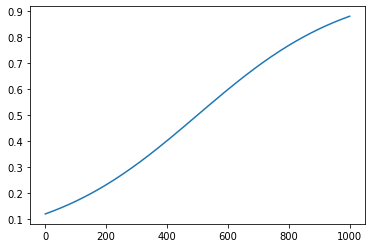

In [ ]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_sig_004)

In [ ]:
df_solution_sig_004 = run_models(alpha_sig_004)

In [ ]:
df_solution_sig_004

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.119203,Optimal,557.0,8610.0,1143.0,0.0,-3797.633779,639.870096,-4398.184623
1,1,0.119624,Optimal,557.0,8610.0,1143.0,0.0,-3795.512576,639.870096,-4398.184623
2,2,0.120046,Optimal,557.0,8610.0,1143.0,0.0,-3793.384902,639.870096,-4398.184623
3,3,0.120470,Optimal,557.0,8610.0,1143.0,0.0,-3791.250744,639.870096,-4398.184623
4,4,0.120895,Optimal,557.0,8610.0,1143.0,0.0,-3789.110090,639.870096,-4398.184623
...,...,...,...,...,...,...,...,...,...,...
995,995,0.879105,Optimal,557.0,8610.0,1143.0,0.0,30.795563,639.870096,-4398.184623
996,996,0.879530,Optimal,557.0,8610.0,1143.0,0.0,32.936217,639.870096,-4398.184623
997,997,0.879954,Optimal,557.0,8610.0,1143.0,0.0,35.070375,639.870096,-4398.184623
998,998,0.880376,Optimal,557.0,8610.0,1143.0,0.0,37.198049,639.870096,-4398.184623


In [ ]:
alpha_sig_06 = sig(-0.06)

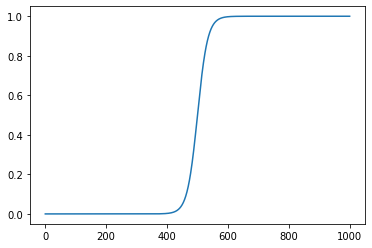

In [ ]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), alpha_sig_06)

In [ ]:
df_solution_sig_06 = run_models(alpha_sig_06)

In [ ]:
df_solution_sig_06

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,9.357623e-14,Optimal,557.0,8610.0,1143.0,0.0,-4398.184623,639.870096,-4398.184623
1,1,9.936863e-14,Optimal,557.0,8610.0,1143.0,0.0,-4398.184623,639.870096,-4398.184623
2,2,1.055196e-13,Optimal,557.0,8610.0,1143.0,0.0,-4398.184623,639.870096,-4398.184623
3,3,1.120513e-13,Optimal,557.0,8610.0,1143.0,0.0,-4398.184623,639.870096,-4398.184623
4,4,1.189873e-13,Optimal,557.0,8610.0,1143.0,0.0,-4398.184623,639.870096,-4398.184623
...,...,...,...,...,...,...,...,...,...,...
995,995,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,639.870096,639.870096,-4398.184623
996,996,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,639.870096,639.870096,-4398.184623
997,997,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,639.870096,639.870096,-4398.184623
998,998,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,639.870096,639.870096,-4398.184623


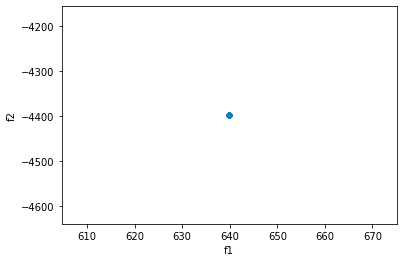

In [ ]:
df_solution_sig_06.plot.scatter(x='f1', y='f2')

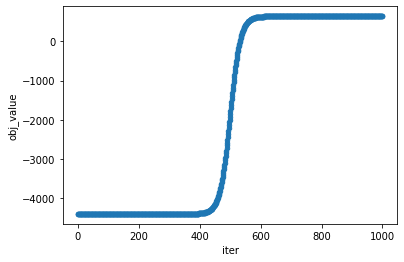

In [ ]:
df_solution_sig_06.plot.scatter(x='iter', y='obj_value')